## makemore: becoming a backprop ninja

In [2]:
# there no change change in the first several cells from last lecture

In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [4]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

zsh:1: command not found: wget


In [5]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [6]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [7]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [8]:
# ok biolerplate done, now we get to the action:

In [9]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [190]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 just for fun, it's useless because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

4137


In [191]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

In [192]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time
print(Xb.shape, C[Xb].shape)
emb = C[Xb] # embed the characters into vectors
print(emb.view(emb.shape[0], -1).shape)
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
# Linear layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()
# dlogbrobs = logits - logits.max(1, keepdim=True).values

# PyTorch backward pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad()
loss.backward()
loss

torch.Size([32, 3]) torch.Size([32, 3, 10])
torch.Size([32, 30])


tensor(3.3484, grad_fn=<NegBackward0>)

In [193]:
#create a random torch tensor of shape (3,2) with a fixed generator seed
torch.manual_seed(42)
nr = 2
nemb = 4
ybtest = torch.randint(0, nemb, (nr,), dtype=torch.int)
# print(ybtest.shape, Yb.shape)
x = torch.rand((nr, nemb),requires_grad=True)
xnorm = x-x.max(1, keepdim=True).values
lp = xnorm - xnorm.exp().sum(1, keepdim=True).log()
lx = lp[range(nr),ybtest]
lf = -lx.mean()
for p in x, lp, lx, lf:
    p.retain_grad()
lf.backward()
x, lp, lx, lf, lp.grad, x.grad, lp.grad

temp = torch.zeros_like(x)
x_values, x_indices = x.max(1, keepdim=True)

lp.grad-temp.scatter(1,x_indices, lp.grad.sum(1, keepdim=True)), x.grad
# x.max(1).indices
dx= x.exp()/2 * x.exp().sum(1, keepdim=True)**-1
print(dx)
dx[range(nr), ybtest] -= 1/nr
# dx.scatter_add_(1, torch.tensor([0,0]).unsqueeze(1), torch.tensor([-0.5]))
dx, x.grad


tensor([[0.0994, 0.1769, 0.1001, 0.1236],
        [0.0897, 0.1534, 0.1777, 0.0792]], grad_fn=<MulBackward0>)


(tensor([[ 0.0994,  0.1769, -0.3999,  0.1236],
         [ 0.0897,  0.1534,  0.1777, -0.4208]], grad_fn=<IndexPutBackward0>),
 tensor([[ 0.0994,  0.1769, -0.3999,  0.1236],
         [ 0.0897,  0.1534,  0.1777, -0.4208]]))

In [194]:
logprobs.shape, logits.shape,  Yb
n

32

In [195]:
# Exercise 1: backprop through the whole thing manually,
# backpropagating through exactly all of the variables
# as they are defined in the forward pass above, one by one

# -----------------
# YOUR CODE HERE :)
dlogprobs = torch.zeros_like(logprobs)
#for the elements being plucked out, we set the gradient to -1/n where n is the batch size
dlogprobs[range(n), Yb] = -1.0/n #gradient is set to -1/batch_size
#gradient dprobs is 1/probs
dprobs = dlogprobs / probs
#gradient of counts_sum_inv is (counts * dprobs).sum(1, keepdim=True)
dcounts_sum_inv = (dprobs * counts).sum(1, keepdim=True)
dcounts_sum = dcounts_sum_inv * (-counts_sum**-2)
dcounts = dprobs*counts_sum_inv + dcounts_sum
dnorm_logits = dcounts*norm_logits.exp()
dlogits = torch.ones_like(logits)*dnorm_logits
dlogit_maxes = -1*dnorm_logits.sum(1, keepdim=True)
dlogits+=torch.zeros_like(logits).scatter(1,logits.max(1,keepdim=True).indices,1) * dlogit_maxes
dh = dlogits@W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(axis = 0, keepdim=True)
dhpreact = dh * (1 - h**2)# either dh*torch.cosh(hpreact)**-2 or dh * (1 - h**2) where h = torch.tanh(hpreact) but the first gives only approximate gradient for some reason
dbngain = (bnraw*dhpreact).sum(axis = 0, keepdim=True)
dbnbias = dhpreact.sum(axis=0, keepdim=True)
dbnraw = bngain * dhpreact
dbnvar_inv = (bndiff*dbnraw).sum(axis=0, keepdim=True)
# bnvar_inv = (bnvar + 1e-5)**-0.5
dbnvar = -0.5*(bnvar + 1e-5)**-1.5* dbnvar_inv
dbndiff2 = torch.ones_like(bndiff2)*1/(n-1) * dbnvar
dbndiff = bnvar_inv*dbnraw + 2*bndiff*dbndiff2
dbnmeani = (-dbndiff).sum(axis = 0)
dhprebn = dbndiff + 1.0/n * (torch.ones_like(hprebn) * dbnmeani)
dembcat = dhprebn@W1.T
dW1 = embcat.T@dhprebn
db1 = dhprebn.sum(axis=0, keepdim=False)
demb = dembcat.view(emb.shape)
dC = torch.zeros_like(C)


# dC now contains the accumulated gradients
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix] += demb[k,j]


# -----------------

cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff:

In [196]:
# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.3484158515930176 diff: -2.384185791015625e-07


In [197]:
dlogits.shape

torch.Size([32, 27])

In [201]:
# backward pass

# -----------------
# YOUR CODE HERE :)
# dlogits = None # TODO. my solution is 3 lines
dlogits = logits.exp()/n * logits.exp().sum(1, keepdim=True)**-1 # this is just softmax
# dlogits = F.softmax(logits,dim=1)/n #alternative
dlogits[range(n), Yb] -= 1/n
# -----------------

cmp('logits', dlogits, logits) # I can only get approximate to be true, my maxdiff is 6e-9

logits          | exact: False | approximate: True  | maxdiff: 8.381903171539307e-09


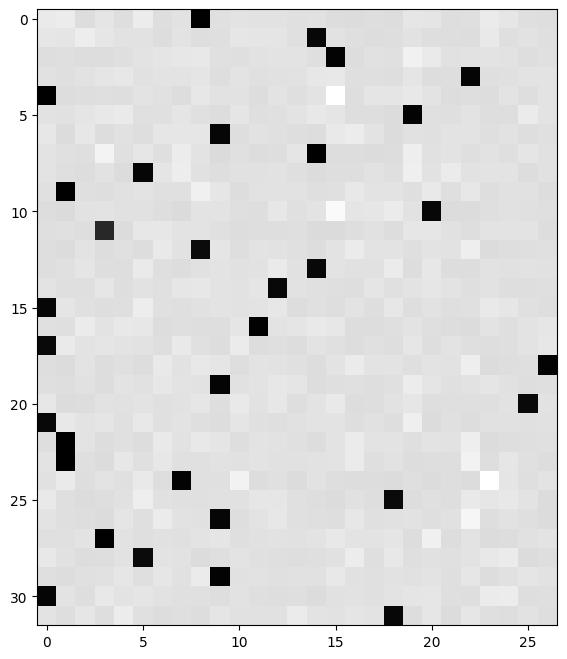

In [205]:
plt.figure(figsize=(8,8))
plt.imshow(dlogits.detach(), cmap='gray')

In [206]:
# Exercise 3: backprop through batchnorm but all in one go
# to complete this challenge look at the mathematical expression of the output of batchnorm,
# take the derivative w.r.t. its input, simplify the expression, and just write it out
# BatchNorm paper: https://arxiv.org/abs/1502.03167

# forward pass

# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


In [207]:
(bndiff/(n-1)*bnvar_inv**3).shape, (bndiff*dhpreact).sum(0, keepdim=True).shape

(torch.Size([32, 64]), torch.Size([1, 64]))

In [210]:
# backward pass

# before we had:
# dbnraw = bngain * dhpreact
# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
# dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
# dbndiff += (2*bndiff) * dbndiff2
# dhprebn = dbndiff.clone()
# dbnmeani = (-dbndiff).sum(0)
# dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
# (you'll also need to use some of the variables from the forward pass up above)

# -----------------
# YOUR CODE HERE :)
dd = -bngain *( (bndiff/(n-1))*bnvar_inv**3*(bndiff*dhpreact).sum(0, keepdim=True) - bnvar_inv*dhpreact)
dhprebn = dd-(1/n)*dd.sum(0,keepdim=True)
# dhprebn = None # TODO. my solution is 1 (long) line
# -----------------

cmp('hprebn', dhprebn, hprebn) # I can only get approximate to be true, my maxdiff is 9e-10
# dhprebn, hprebn.grad

hprebn          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


In [158]:
bngain.shape, bnraw.shape, hpreact.shape, dhpreact.shape
# bngain.shape = (dhpreact*bnraw).sum(0, keepdim=True).shape

(torch.Size([1, 200]),
 torch.Size([32, 200]),
 torch.Size([32, 200]),
 torch.Size([32, 64]))

In [213]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass

# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
with torch.no_grad():

  # kick off optimization
  for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hprebn = embcat @ W1 + b1 # hidden layer pre-activation
    # BatchNorm layer
    # -------------------------------------------------------------
    bnmean = hprebn.mean(0, keepdim=True)
    bndiff = hprebn - bnmean
    bnvar = hprebn.var(0, keepdim=True, unbiased=True)
    bnvar_inv = (bnvar + 1e-5)**-0.5
    bnraw = (hprebn - bnmean) * bnvar_inv
    hpreact = bngain * bnraw + bnbias

    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    # for p in parameters:
    #   p.grad = None
    # loss.backward() # use this for correctness comparisons, delete it later!

    # manual backprop! #swole_doge_meme
    # -----------------
    # YOUR CODE HERE :)
    # with torch.no_grad():
    #dlogits from above
    dlogits = logits.exp()/n * logits.exp().sum(1, keepdim=True)**-1
    dlogits[range(n), Yb] -= 1/n
    #dh next
    dh = dlogits@W2.T
    #dhpreact next
    dhpreact = (1-h**2)*dh
    #now the batchnorm
    dd = -bngain * (bndiff/(n-1))*bnvar_inv**3*(bndiff*dhpreact).sum(0, keepdim=True) + bngain*bnvar_inv*dhpreact
    dhprebn = dd-(1/n)*dd.sum(0,keepdim=True)
    
    #now the embedding part
    dembcat = dhprebn@W1.T
    demb = dembcat.view(emb.shape)
    dC = torch.zeros_like(C)
    # dC now contains the accumulated gradients
    for k in range(Xb.shape[0]):
        for j in range(Xb.shape[1]):
            ix = Xb[k,j]
            dC[ix] += demb[k,j]
      
    dW1, db1, dW2 = embcat.T@dhprebn, dhprebn.sum(0, keepdim=False), h.T@dlogits 
    db2 = dlogits.sum(0, keepdim=False)
    dbngain = (dhpreact*bnraw).sum(0, keepdim=True)
    dbnbias = dhpreact.sum(0, keepdim=True)
    grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
    # -----------------

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p, grad in zip(parameters, grads):
      # p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
      p.data += -lr * grad # new way of swole doge TODO: enable

    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    if i >= 1000: # TODO: delete early breaking when you're ready to train the full net
      break

12297
      0/ 200000: 3.8159


In [222]:
demb.shape, Xb.shape

(torch.Size([32, 3, 10]), torch.Size([32, 3]))

In [ ]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass
import mlx.core as mx
# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
with torch.no_grad():

  # kick off optimization
  for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hprebn = embcat @ W1 + b1 # hidden layer pre-activation
    # BatchNorm layer
    # -------------------------------------------------------------
    bnmean = hprebn.mean(0, keepdim=True)
    bndiff = hprebn - bnmean
    bnvar = hprebn.var(0, keepdim=True, unbiased=True)
    bnvar_inv = (bnvar + 1e-5)**-0.5
    bnraw = (hprebn - bnmean) * bnvar_inv
    hpreact = bngain * bnraw + bnbias

    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    # for p in parameters:
    #   p.grad = None
    # loss.backward() # use this for correctness comparisons, delete it later!

    # manual backprop! #swole_doge_meme
    # -----------------
    # YOUR CODE HERE :)
    # with torch.no_grad():
    #dlogits from above
    dlogits = logits.exp()/n * logits.exp().sum(1, keepdim=True)**-1
    dlogits[range(n), Yb] -= 1/n
    #dh next
    dh = dlogits@W2.T
    #dhpreact next
    dhpreact = (1-h**2)*dh
    #now the batchnorm
    dd = -bngain * (bndiff/(n-1))*bnvar_inv**3*(bndiff*dhpreact).sum(0, keepdim=True) + bngain*bnvar_inv*dhpreact
    dhprebn = dd-(1/n)*dd.sum(0,keepdim=True)
    
    #now the embedding part
    dembcat = dhprebn@W1.T
    demb = dembcat.view(emb.shape)
    dC = torch.zeros_like(C)
    # dC now contains the accumulated gradients
    for k in range(Xb.shape[0]):
        for j in range(Xb.shape[1]):
            ix = Xb[k,j]
            dC[ix] += demb[k,j]
      
    dW1, db1, dW2 = embcat.T@dhprebn, dhprebn.sum(0, keepdim=False), h.T@dlogits 
    db2 = dlogits.sum(0, keepdim=False)
    dbngain = (dhpreact*bnraw).sum(0, keepdim=True)
    dbnbias = dhpreact.sum(0, keepdim=True)
    grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
    # -----------------

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p, grad in zip(parameters, grads):
      # p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
      p.data += -lr * grad # new way of swole doge TODO: enable

    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    if i >= 1000: # TODO: delete early breaking when you're ready to train the full net
      break

12297
      0/ 200000: 3.8159


In [220]:
print(dW1.shape, W1.shape)
cmp(str(tuple(W1.shape)), dW1, W1)

torch.Size([30, 200]) torch.Size([30, 200])


TypeError: all(): argument 'input' (position 1) must be Tensor, not bool

In [216]:
# useful for checking your gradients
for p,g in zip(parameters, grads):
  print(p.shape,g.shape)
  cmp(str(tuple(p.shape)), g, p)

torch.Size([27, 10]) torch.Size([27, 10])


TypeError: all(): argument 'input' (position 1) must be Tensor, not bool

In [217]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnvar = hpreact.var(0, keepdim=True, unbiased=True)


In [185]:
# evaluate train and val loss

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.069382429122925
val 2.1108837127685547


In [ ]:
# I achieved:
# train 2.0718822479248047
# val 2.1162495613098145

In [186]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass
      emb = C[torch.tensor([context])] # (1,block_size,d)
      embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
      hpreact = embcat @ W1 + b1
      hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ W2 + b2 # (N, vocab_size)
      # sample
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

carlah.
amille.
khi.
mri.
reetleenanden.
jazon.
nadelynn.
jareei.
nellara.
chaiiv.
kaleigh.
ham.
joce.
quint.
salin.
alianni.
watell.
dearisi.
jace.
pirra.
